Simulated Patients

In [37]:

import os
import gym
import random

import pandas as pd
import numpy as np
from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier
from environment.fogg_behavioural_model import Patient 
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper
from stable_baselines3.common.vec_env import DummyVecEnv

# Experimental settings

In [38]:
# 500 runs in the paper
runs = 1

## Patients

In [39]:
num_p = 80 # number of patients
# how patient vary
v_prefered_activity = True
v_motivation = True
v_prefered_time = True


#defauts
behaviour_threshold=30
prefered_activity =1
motivated_by =2
good_time = 0

## Condition

In [40]:
#basic stable condition
condition = 'stable'
habituation=False
time_preference_update_step= 9999999999999999 #very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift

#Other options:
# condition = 'habituated'
# habituation=True
# time_preference_update_step= 9999999999999999 

# condition = 'changed_preference'
# habituation=False
# time_preference_update_step= five_weeks

# condition = 'habituated_changed_preference'
# habituation=True
# time_preference_update_step= five_weeks

In [41]:
results_directory = 'results_varried_bt{}_n{}_a{}_m{}_t{}'.format(behaviour_threshold,num_p, v_prefered_activity, v_motivation, v_prefered_time )
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

## Training time frame

In [83]:
# number of weeks for initial supervised model training
sweeks = 3

updated_every_day = 24 
week= 7 * updated_every_day

eight_weeks = week * 8
five_weeks = week * 5

# No interverntion

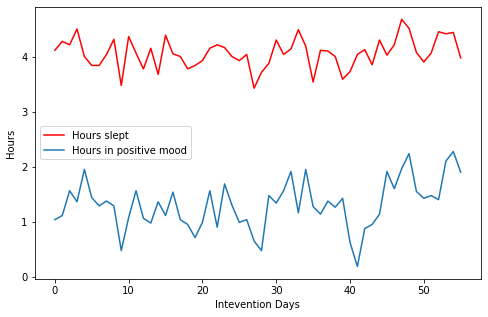

In [43]:
sleep_list = []
positive_list = []

for run in range(0, runs):
    
    envlist = []
    for i in range(num_p):
        if v_prefered_activity:
            prefered_activity = random.randint(0,3)
        if v_motivation:
            motivated_by = random.randint(0,3)
        if v_prefered_time:
            good_time = random.randint(0,3)
        env = Patient(behaviour_threshold=behaviour_threshold,id=i, preferred_activity=prefered_activity, motivated_by=motivated_by, good_time=good_time,
                      habituation=habituation, time_preference_update_step=time_preference_update_step,  num_all_pat=num_p)
        envlist.append(env)
    
    def turn2lambda(e):
        return lambda: e
    el = [turn2lambda(e) for e in envlist]
    # env1 = gym.vector.SyncVectorEnv( el )
    env1 = DummyVecEnv(el)
    action = [[0,0,0,0] for a in range(len(envlist)) ]
    
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        
    h_slept = np.mean([env1.envs[i].h_slept for i in range(num_p)], axis=0) 
    h_positive = np.mean([env1.envs[i].h_positive for i in range(num_p)], axis=0) 
    sleep_list.append(h_slept)
    positive_list.append(h_positive)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

In [44]:
env1.envs[0].selected_actions

[[0, 0, 0, 0]]

# Intervention

In [45]:
def intervention(method, runs, name, condition, num_p=num_p, vec_env=DummyVecEnv):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    for run in range(0, runs):

        envlist = []
        for i in range(num_p):
            if v_prefered_activity:
                prefered_activity = random.randint(0,3)
            if v_motivation:
                motivated_by = random.randint(0,3)
            if v_prefered_time:
                good_time = random.randint(0,3)
            env = Patient(behaviour_threshold=behaviour_threshold,id=i, preferred_activity=prefered_activity, motivated_by=motivated_by, good_time=good_time,
                          habituation=habituation, time_preference_update_step=time_preference_update_step,  num_all_pat=num_p)
            envlist.append(env)

        def turn2lambda(e):
            return lambda: e
        el = [turn2lambda(e) for e in envlist]
        # env1 = gym.vector.SyncVectorEnv( el )
        env1 = vec_env(el)
        # env1 = VecExtractDictObs(env1, key="observation")
        env1 = method(env1)
        if np.sum([env1.envs[i].num_performed for i in range(num_p)], axis=0).any():
            performed += 1
        df = pd.DataFrame()
        df['responce_ratio'] =  np.nanmean([env1.envs[i].rr for i in range(num_p)], axis=0) 
        df['activity performed'] = np.mean([env1.envs[i].num_performed for i in range(num_p)], axis=0)  
        df['notifications'] = np.mean([env1.envs[i].num_notified for i in range(num_p)], axis=0)  
        df['sleep'] = np.mean([env1.envs[i].h_slept for i in range(num_p)], axis=0) 
        df['positive'] = np.mean([env1.envs[i].h_positive for i in range(num_p)], axis=0) 
        df['non_stationary'] = np.mean([env1.envs[i].h_nonstationary for i in range(num_p)], axis=0)
        df.to_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory, condition, name, run))
        
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)

    
    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.nanmean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
    ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
    ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
    ax2.set_xlabel('Intervention Days')
    ax2.set_ylabel('No. notifications')
    ax1.set_ylabel('Responce ratio')
    plt.show()
    return env1

## Heuristic

Notify every hour except in night and when the patinets is alseep

In [46]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    actions = [[0,0,0,0] for e in range(len(env1.envs))]
    for i in  range(intervention_legth):
        # print(actions)
        observations, reward, done, info = env1.step(actions)
        # print(observations)
        actions = []
        for observation in observations:
            if observation[10] == 3 or observation[3] ==1:
                action = [0,0,0,0]
            else:
                action = [1,0,0,0]
            actions.append(action)
        # print(actions)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
0 out of 1 resulted in activity being performed 


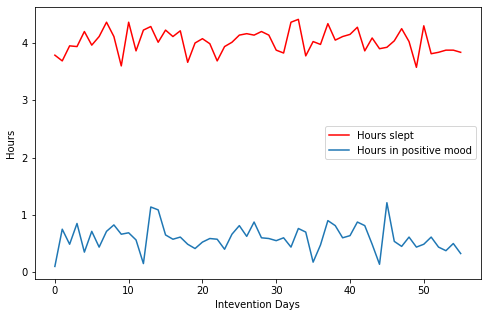

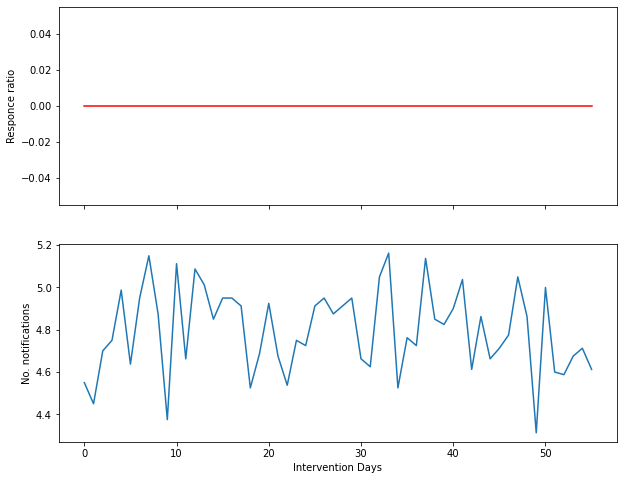

In [47]:
_ = intervention(always_notify, runs, 'h', condition, vec_env= gym.vector.SyncVectorEnv)

## Random 
Randomly sample during the day skip the nights

In [48]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    actions = [[0,0,0,0] for e in range(len(env1.envs))]
    for i in  range(intervention_legth):
        
        observations, reward, done, info = env1.step(actions)
        actions = env1.action_space.sample()
    return env1

This figures include runs in which no prompt resulted in the activity being performed
1 out of 1 resulted in activity being performed 


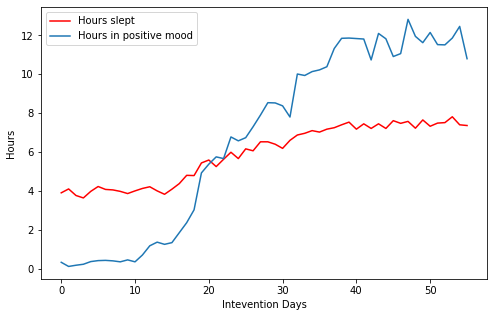

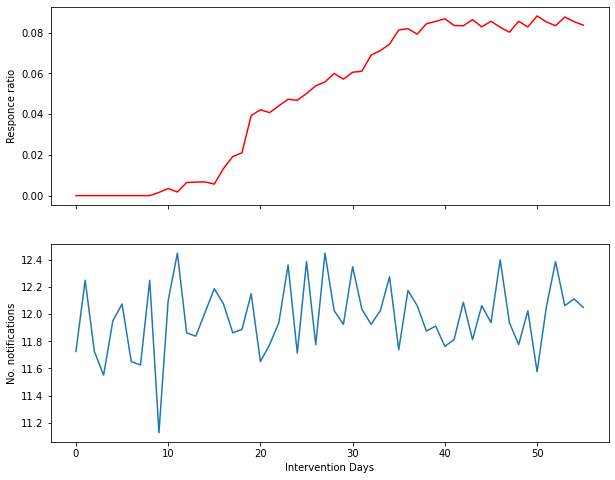

In [49]:
_ = intervention(random_notification, runs, 'random', condition, vec_env= gym.vector.SyncVectorEnv)

In [50]:
def get_rr_and_notification(name, runs, condition):
    
    rr, noti = [],[]
    failed = 0
    for run in range(runs):
        df = pd.read_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory,condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0: # activity performed at least once in the course of the intervention
            rr.append(df.responce_ratio)
            noti.append(df.notifications)
        else:
            failed = failed +1 
    print(" {0} out of {1} runs had no activity performed throught the full intervention.".format(failed, runs))
    return rr, noti, failed

In [51]:
rr_random_list, not_random_list, fppo = get_rr_and_notification('random', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


## Supervised Learning

### static model

In [84]:
def supervised(env1):
    
    weeks = 24 * 7 * sweeks
    env1 = random_notification(env1, intervention_legth=weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    o = np.concatenate([env1.envs[i].observation_list for i in range(len(env1.envs))])
    a = np.concatenate([env1.envs[i].selected_actions for i in range(len(env1.envs))])
    clf.fit(o,a)
    remaining_time = eight_weeks - weeks
    observation = env1.observations
    for i in range(remaining_time):
        action = clf.predict(observation)
        observation, reward, done, info = env1.step(action)
        
    return env1

This figures include runs in which no prompt resulted in the activity being performed
1 out of 1 resulted in activity being performed 


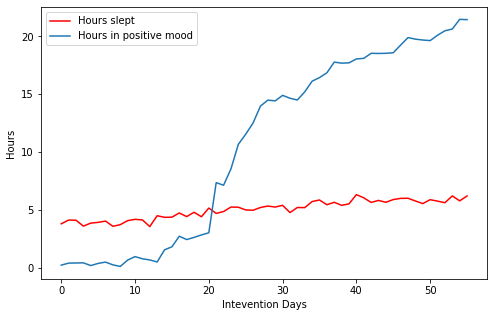

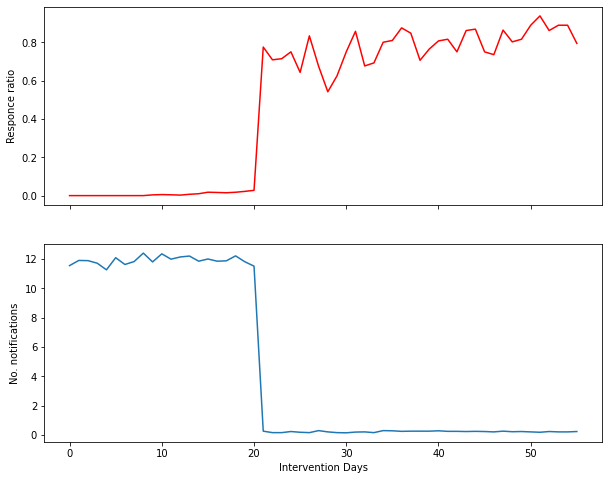

In [85]:
es =intervention(supervised, runs , 'static_sup{0}'.format(sweeks), condition, vec_env= gym.vector.SyncVectorEnv)

In [86]:
def notify_decisions_from_last_run(e):
        for i in range(num_p):
            print("Patient {0}".format(i))
            
            print("Prefered activity {0}, motivated by {1}".format(e.envs[i].preferred_activity, e.envs[i].motivated_by))
            print("Only decisions to notify: [notify, actitvity, motivation, difficulty]")
            print([i for i in e.envs[i].selected_actions if i[0]==1])
            print("")

In [87]:
notify_decisions_from_last_run(es)

Patient 0
Prefered activity 3, motivated by 1
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 3, 1, 2], [1, 0, 0, 0], [1, 2, 1, 2], [1, 3, 1, 2], [1, 3, 3, 1], [1, 2, 3, 0], [1, 3, 2, 2], [1, 0, 3, 1], [1, 0, 1, 2], [1, 2, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2], [1, 0, 1, 2]]

Patient 1
Prefered activity 2, motivated by 2
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 0, 0, 0], [1, 0, 2, 2]]

Patient 2
Prefered activity 0, motivated by 1
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 0, 1, 0], [1, 0, 3, 2], [1, 0, 3, 0], [1, 0, 1, 1], [1, 2, 1, 1], [1, 1, 1, 1], [1, 2, 1, 2], [1, 0, 2, 2], [1, 0, 2, 2], [1, 0, 2, 0]]

Patient 3
Prefered activity 3, motivated by 1
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 3, 1, 2], [1, 1, 2, 1], [1, 0, 2, 2], [1, 0, 2, 2], [1, 0, 2, 2]]

Patient 4
Prefered activ

### adaptive model 

In [88]:
def supervised_adaptive(env1):
    
    weeks = 24 * 7 *sweeks
    env1 = random_notification(env1, intervention_legth=weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    o = np.concatenate([env1.envs[i].observation_list for i in range(len(env1.envs))])
    a = np.concatenate([env1.envs[i].selected_actions for i in range(len(env1.envs))])
    clf.fit(o,a)
    remaining_time = eight_weeks - weeks
    observation = observation = env1.observations
    samples = o.shape[0]
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(observation)
        observation, reward, done, info = env1.step(action)
        o = np.concatenate([env1.envs[i].observation_list for i in range(len(env1.envs))])
        if o.shape[0]> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            a = np.concatenate([env1.envs[i].selected_actions for i in range(len(env1.envs))])
            clf.fit(o,a)
            samples = o.shape[0]

    return env1

This figures include runs in which no prompt resulted in the activity being performed
1 out of 1 resulted in activity being performed 


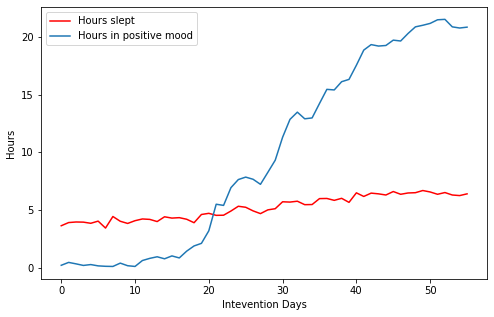

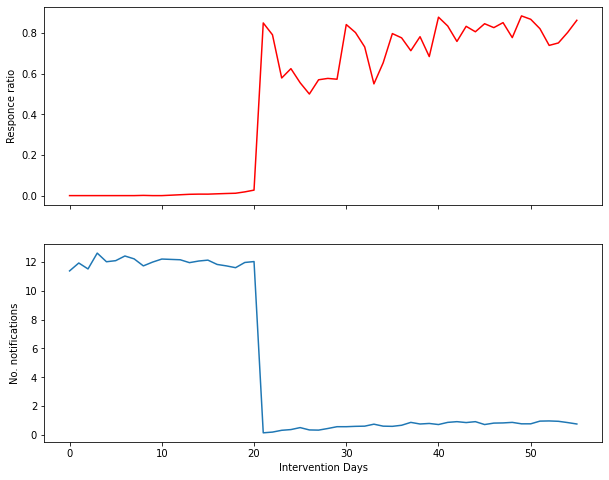

In [89]:
ea = intervention(supervised_adaptive, runs, 'adaptive_sup{0}'.format(sweeks), condition, vec_env= gym.vector.SyncVectorEnv)

In [90]:
notify_decisions_from_last_run(ea)

Patient 0
Prefered activity 0, motivated by 2
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 0, 2, 1], [1, 0, 2, 2], [1, 2, 0, 2], [1, 3, 0, 2], [1, 3, 0, 2], [1, 3, 0, 0]]

Patient 1
Prefered activity 2, motivated by 0
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 2, 2, 2], [1, 3, 0, 2], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 2], [1, 3, 0, 2], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 2], [1, 3, 0, 2], [1, 3, 0, 2], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 2], [1, 3, 0, 2], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 2], [1, 3, 0, 2], [1, 3, 0, 0], [1, 3, 0, 0], [1, 3, 0, 0]]

Patient 2
Prefered activity 1, motivated by 0
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 1, 0, 0], [1, 3, 0, 1], [1, 1, 3, 0], [1, 1, 0, 0], [1, 1, 0, 0], [1, 0, 0, 0], [1, 3, 0, 1], [1, 1, 0, 0], [1, 1, 0, 0], [1, 3, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0], [1, 3, 0, 2], [1,

### How many times supervised training faild?

In [91]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup{0}'.format(sweeks), runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [92]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup{0}'.format(sweeks), runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


## Deep Q Network

In [61]:
#  does not support multi discreate actions!!

## Proximal Policy Optimisation

In [62]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day, batch_size=updated_every_day)
    model.learn(total_timesteps=eight_weeks*num_p)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
1 out of 1 resulted in activity being performed 


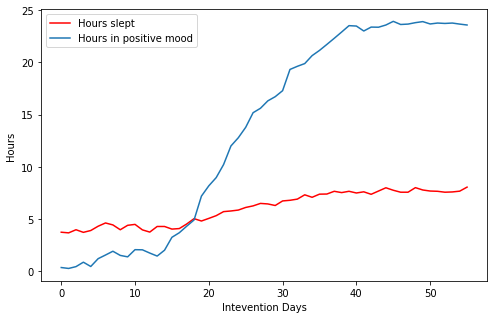

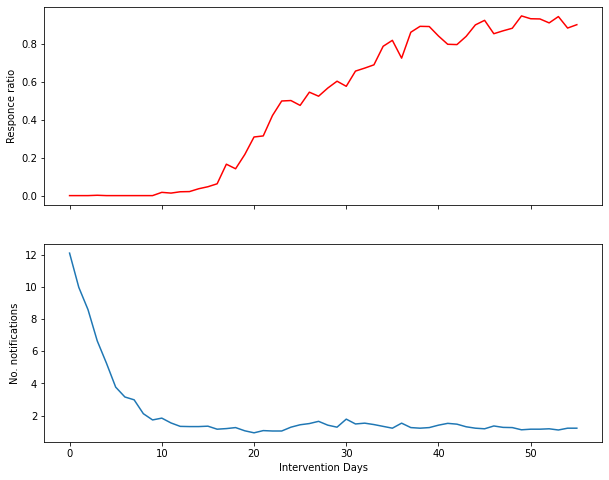

In [63]:
ep= intervention(ppo, runs, 'ppo', condition)

In [64]:
notify_decisions_from_last_run(ep)

Patient 0
Prefered activity 2, motivated by 3
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 0, 1, 1], [1, 3, 3, 0], [1, 2, 3, 1], [1, 2, 1, 0], [1, 2, 2, 1], [1, 0, 3, 1], [1, 3, 3, 1], [1, 2, 0, 2], [1, 3, 3, 1], [1, 3, 1, 1], [1, 3, 2, 1], [1, 2, 0, 2], [1, 2, 2, 2], [1, 0, 1, 1], [1, 2, 0, 0], [1, 2, 2, 1], [1, 2, 0, 1], [1, 2, 2, 1], [1, 3, 1, 2], [1, 2, 2, 1], [1, 0, 3, 1], [1, 0, 2, 2], [1, 1, 0, 1], [1, 3, 3, 1], [1, 3, 0, 1], [1, 1, 3, 1], [1, 1, 2, 1], [1, 1, 2, 0], [1, 1, 3, 1], [1, 3, 2, 1], [1, 0, 2, 1], [1, 1, 1, 0]]

Patient 1
Prefered activity 2, motivated by 1
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 2, 1, 0], [1, 2, 1, 2], [1, 2, 2, 2], [1, 2, 3, 2], [1, 0, 3, 0], [1, 2, 1, 0], [1, 1, 0, 0], [1, 2, 1, 2], [1, 0, 1, 1], [1, 3, 1, 0], [1, 3, 1, 0], [1, 2, 1, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 1, 1], [1, 3, 1, 1], [1, 1, 0, 1], [1, 2, 0, 0], [1, 3, 1, 0], [1, 0, 1, 1], [1, 0, 1, 0], [1, 1, 0, 0], [1, 2, 0,

In [65]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [66]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks*num_p)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
1 out of 1 resulted in activity being performed 


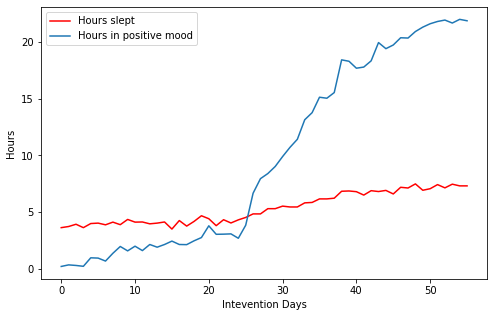

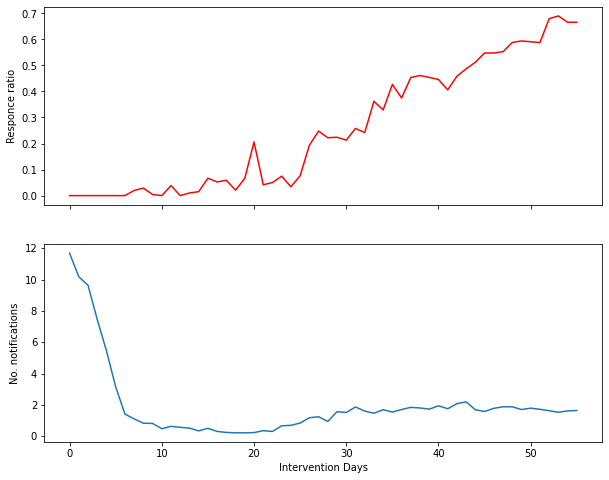

In [67]:
eac = intervention(a2c, runs, 'a2c', condition)

In [68]:
notify_decisions_from_last_run(eac)

Patient 0
Prefered activity 0, motivated by 0
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 0, 3, 0], [1, 0, 3, 2], [1, 2, 0, 1], [1, 1, 0, 0], [1, 1, 2, 1], [1, 3, 0, 0], [1, 3, 0, 0], [1, 2, 0, 0], [1, 0, 2, 1], [1, 0, 2, 1], [1, 3, 1, 2], [1, 1, 3, 0], [1, 3, 1, 0], [1, 0, 2, 0], [1, 2, 3, 0], [1, 0, 3, 2], [1, 0, 0, 1], [1, 1, 1, 1], [1, 1, 2, 2]]

Patient 1
Prefered activity 3, motivated by 2
Only decisions to notify: [notify, actitvity, motivation, difficulty]
[[1, 3, 3, 1], [1, 3, 2, 0], [1, 3, 2, 2], [1, 0, 3, 1], [1, 0, 3, 2], [1, 3, 3, 1], [1, 2, 0, 1], [1, 3, 2, 0], [1, 3, 2, 0], [1, 2, 1, 1], [1, 3, 1, 1], [1, 3, 0, 1], [1, 0, 3, 1], [1, 1, 2, 2], [1, 2, 2, 0], [1, 1, 3, 1], [1, 1, 2, 1], [1, 1, 2, 1], [1, 2, 2, 0], [1, 3, 0, 0], [1, 2, 1, 1], [1, 2, 2, 0], [1, 2, 3, 2], [1, 1, 1, 2], [1, 0, 0, 1], [1, 2, 1, 1], [1, 0, 1, 1], [1, 0, 2, 0], [1, 0, 3, 2], [1, 2, 2, 2]]

Patient 2
Prefered activity 1, motivated by 1
Only decisions to notify: [notif

In [69]:
rr_a2c_list, not_a2c_list, fppo = get_rr_and_notification('a2c', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


## Comparison between prompt learning stategies

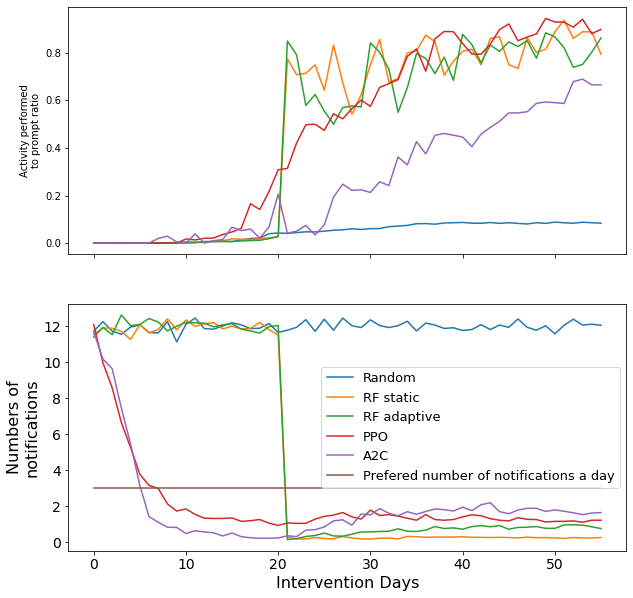

In [93]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static ()')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
# ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')


ax2.plot(np.nanmean(not_random_list, axis=0), label='Random')
ax2.plot(np.nanmean(not_rf3_list, axis=0), label='RF static')
ax2.plot(np.nanmean(not_rf3a_list, axis=0), label='RF adaptive')
# ax2.plot(np.nanmean(not_dqn_list, axis=0), label='DQN')
ax2.plot(np.nanmean(not_ppo_list, axis=0), label='PPO')
ax2.plot(np.nanmean(not_a2c_list, axis=0), label='A2C')
ax2.plot(np.ones(len(np.mean(not_random_list, axis=0))) +2, label ='Prefered number of notifications a day')

ax2.set_xlabel('Intervention Days', fontsize=16)
ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
# ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
# plt.ylim(0, 0.95)
ax2.legend(fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Plots

In [71]:
runs =1
#basic stable condition
condition = 'stable'

#Other options:
# condition = 'habituated'
# condition = 'changed_preference'
# condition = 'habituated_changed_preference'

In [73]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup{0}'.format(sweeks), runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [75]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup{0}'.format(sweeks), runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [76]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [77]:
rr_a2c_list, not_a2c_list, fa2c = get_rr_and_notification('a2c', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [78]:
rr_random_list, not_random_list, frandom = get_rr_and_notification('random', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [79]:
shift = 7* 5

In [80]:
intervention_length = 7*8

C:\Users\AnetaLisowska\Anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\AnetaLisowska\Anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


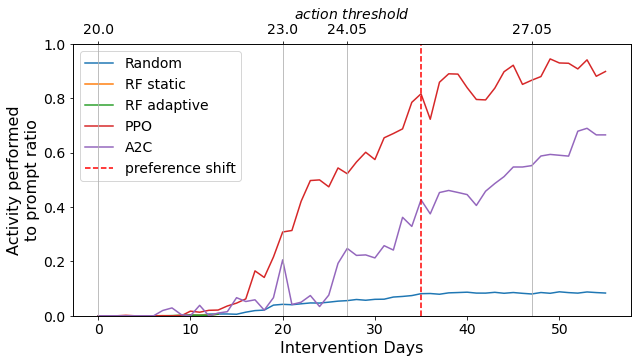

In [82]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10,5))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
# ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')
ax1.vlines(shift , 0, 1, linestyles='dashed', color='red', label='preference shift' )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2 = ax1.twiny()
def tick_function(X):
    V = 20 + 0.15 * X
    return V

new_tick_locations = np.array([0, 20, 27, 47])
ax2.grid(True)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel('$ \it{action}$ $\it{threshold}$', fontsize=14 )
ax1.set_xlabel('Intervention Days', fontsize=16 )
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)), fontsize=16 )
plt.ylim(0, 1.0)
ax1.legend( fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Intervention vs. No Intervention

Simulated patients who habituate to prompts and changes preference to be notified in the evening after 5 weeks of intervention

In [ ]:
habituation=False
time_preference_update_step= 99999999
condition = 'habituated_changed_preference'

In [ ]:
sleep_list = []
positive_list = []
walking_list = []

for run in range(0, runs):
    
    env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step)
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
        
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)
    walking_list.append(env1.h_nonstationary)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.plot(np.mean(walking_list, axis=0), label='Hours active')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

In [ ]:
def get_patient_state_progress(condition, name, runs):
    
    walking = []
    sleeping = []
    positive = []
    for run in range(runs):
        df = pd.read_csv('{3}/patient1_{0}_{1}_run{2}.csv'.format(condition, name, run, results_directory))
        a_performed = sum(df['activity performed'].values)
        if a_performed >0:
            walking.append(df.non_stationary)
            sleeping.append(df.sleep)
            positive.append(df.positive)
    return walking, sleeping, positive
    

In [ ]:
walkingh, sleep_listh, positive_listh = get_patient_state_progress(condition, 'h', runs)

In [ ]:
walking_ppo, sleep_list_ppo, positive_list_ppo = get_patient_state_progress(condition, 'ppo', runs)

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(16, 4))
ax[0].plot(np.nanmean(sleep_list, axis=0), label='Slept', color ='r')
ax[0].plot(np.mean(positive_list, axis=0), label='In positive mood')
ax[0].plot(np.mean(walking_list, axis=0), label='Non-stationary activity')
ax[1].plot(np.nanmean(sleep_listh, axis=0), label='Hours slept', color ='r')
ax[1].plot(np.mean(positive_listh, axis=0), label='Hours in positive mood')
ax[1].plot(np.mean(walkingh, axis=0), label='Active')
ax[2].plot(np.nanmean(sleep_list_ppo, axis=0), label='Hours slept', color ='r')
ax[2].plot(np.mean(positive_list_ppo, axis=0), label='Hours in positive mood')
ax[2].plot(np.mean(walking_ppo, axis=0), label='Active')
ax[0].set_ylabel('Hours', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Intevention Days', fontsize=14)
ax[1].set_xlabel('Intevention Days', fontsize=14)
ax[2].set_xlabel('Intevention Days', fontsize=14)
ax[0].set_title('No intervention', fontsize=14)
ax[1].set_title('Intervention with hourly prompts', fontsize=14)
ax[2].set_title("Intervention with 'timely' prompts", fontsize=14)